## This notebook implements KNN(K Nearest Neighbor) Classifier algorithm

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import heapq

np.random.seed(42)

#### 2-D matrix input data consisting of 100 synthetic samples to + even split of binary class labels as last column
| dim1 | dim2 | label |
|------|------|-------|
|x11|x12|y1|
|x21|x22|y2|
|  ... |  ... |  ...  | 
|x1001|x1002|y100|

In [20]:
number_of_synthetic_samples = 100

#### class 0's dimension 1 to be drawn from Guassian distribution with mean of -2 & standard deviation of 2, assume half of sample size is labeled class 0

In [21]:
dim1_class0_input = np.random.normal(loc=-2.0, scale=2.0, size=number_of_synthetic_samples//2)
dim1_class0_input.shape

(50,)

#### class 1's dimension 1 to be drawn from Guassian distribution with mean of +2 & standard deviation of 2, assume half of sample size is labeled class 1

In [22]:
dim1_class1_input = np.random.normal(loc=2.0, scale=2.0, size=number_of_synthetic_samples//2)
dim1_class1_input.shape

(50,)

#### dim1 column = (dim1_class0 (50 samples w specified population parameters of dim1_class0) + dim1_class1 (50 samples w specified population parameters of dim1_class1))

In [23]:
all_dim1_input = np.concatenate((dim1_class0_input, dim1_class1_input,), axis=0)
all_dim1_input.shape

(100,)

#### class 0's & class 1's dimension 2 are both to be drawn from Normal dist. with mean of 0 & and standard deviation of 1

In [24]:
all_dim2_input = np.random.normal(loc=0.0, scale=1.0, size=number_of_synthetic_samples)
all_dim2_input.shape

(100,)

#### since dim1 column = dim1_class0 (50 samples w specified population parameters of dim1_class0) + dim1_class1 (50 samples w specified population parameters of dim1_class1), 1st 50 must be labeled 0 & 2nd 50 labeled 1

In [25]:
class0_labels = [0]*(number_of_synthetic_samples//2)
class1_labels = [1]*(number_of_synthetic_samples//2)
all_labels = class0_labels+class1_labels
print(f'1st 50 labels:{all_labels[:50]}\n2nd 50 labels:{all_labels[50:]}')

1st 50 labels:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2nd 50 labels:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


#### turn matrix into dataframe with 100 rows (observations) & 2+1 columns, 2(features/dimensions) + 1(labels)

In [26]:
df = pd.DataFrame({'dim1':all_dim1_input, 'dim2': all_dim2_input, 'labels':all_labels}, columns=['dim1','dim2','labels'])
df.head(10)

,dim1,dim2,labels
0,-1.006572,-1.415371,0
1,-2.276529,-0.420645,0
2,-0.704623,-0.342715,0
3,1.046060,-0.802277,0
4,-2.468307,-0.161286,0
5,-2.468274,0.404051,0
6,1.158426,1.886186,0
7,-0.465131,0.174578,0
8,-2.938949,0.257550,0
9,-0.914880,-0.074446,0


Text(0, 0.5, 'dimension2')

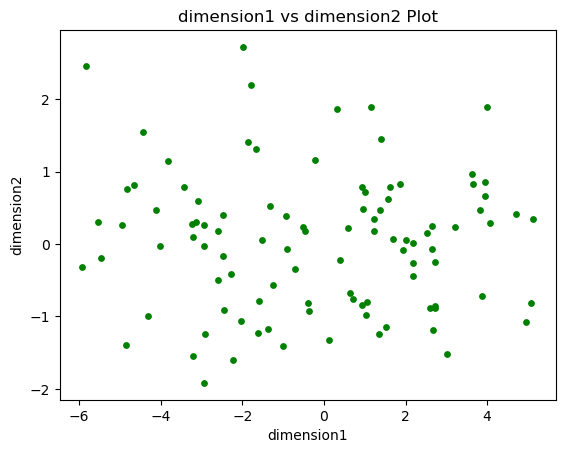

In [27]:
plt.scatter(x=all_dim1_input, y=all_dim2_input, s=15, c='g')
plt.title('dimension1 vs dimension2 Plot')
plt.xlabel('dimension1')
plt.ylabel('dimension2')

#### dimension1 data points are more disperesed, making data more separable for classification and pattern recignition

Text(0, 0.5, 'labels')

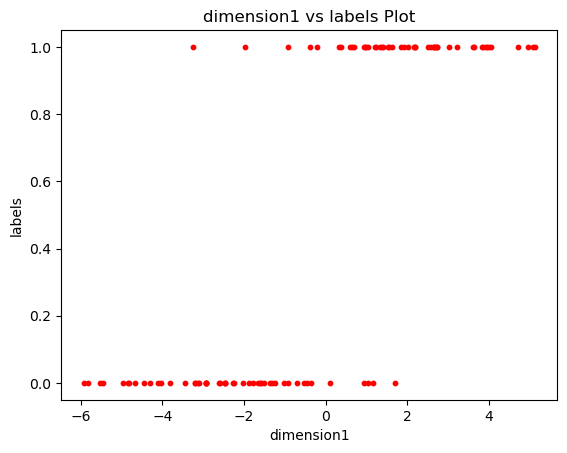

In [28]:
plt.scatter(x=all_dim1_input, y=all_labels, s=10, c='r')
plt.title('dimension1 vs labels Plot')
plt.xlabel('dimension1')
plt.ylabel('labels')

#### dimension2 data points are not disperesed or separable, neither of two impose a clear pattern for classifier

Text(0, 0.5, 'labels')

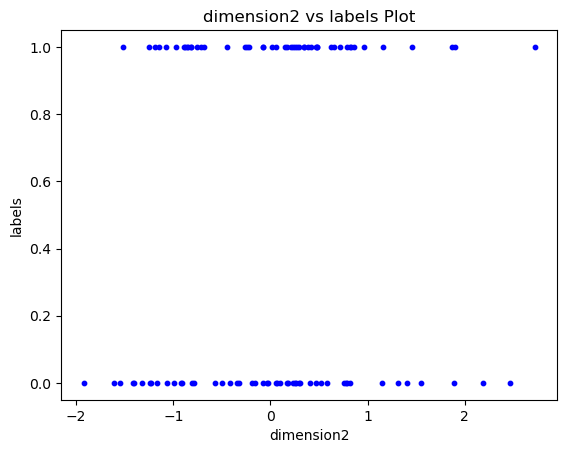

In [29]:
plt.scatter(x=all_dim2_input, y=all_labels, s=10, c='b')
plt.title('dimension2 vs labels Plot')
plt.xlabel('dimension2')
plt.ylabel('labels')

#### splitData() function wraps around train_test_split() from sklearn.model_selection to perform a default 80/20 split between training & holdout set regardless of dataFrame's dimensions, assuming dataFrame's last column consists of class labels

In [30]:
def splitData(dataFrame: pd.DataFrame, training_set_size: float = 0.8, holdout_set_size: float = 0.2) -> pd.DataFrame:
  if training_set_size+holdout_set_size!=1.0:
    raise Exception(f"Provided split (training: {training_set_size}, test: {holdout_set_size}) is NOT possible\nThe splits sum should be 1.0 ")
  return train_test_split(dataFrame, train_size=training_set_size, test_size=holdout_set_size, random_state=42)

In [31]:
training_set, holdout_set = splitData(df)
training_set.shape, holdout_set.shape

((80, 3), (20, 3))

#### knn() algorithm (dimension agonist) calculates distance of new_observation to every point in ref_dataFrame and classifies a label for new_observation based on majority vote of neighbors (majority of neighbor labels)
#### *assumes last column of new_observation and ref_dataFrame are labels

In [32]:
from numpy import sqrt


def knn(new_observation: pd.Series, ref_dataFrame: pd.DataFrame, k: int = 3) -> float:
  distances = [] #min_heap
  majority_vote = {i:0 for i in range(int(ref_dataFrame.iloc[:,-1].max())+1)}
  for i in range(len(ref_dataFrame)): #for each observation in ref_dataFrame
    ref_observation = ref_dataFrame.iloc[i]
    distance = 0
    for j in range(len(ref_observation)-1): #for each dimension of observation
      ref_dim = ref_observation.iloc[j]
      new_dim = new_observation.iloc[j]
      distance = sqrt(distance + (ref_dim-new_dim)**2)
    heapq.heappush(distances, (distance, i))
  
  for i in range(k):
    voter_index = heapq.heappop(distances)[-1]
    voters_label = ref_dataFrame.iloc[voter_index,-1]
    majority_vote[voters_label] += 1
    
  return max(majority_vote, key=majority_vote.get)

In [33]:
predicted_holdout_set = holdout_set.copy()
incorrect_predicted_labels = 0
for i in range(len(holdout_set)):
  predicted_label = knn(holdout_set.iloc[i, :-1], training_set)
  predicted_holdout_set.iloc[i,-1] = predicted_label
  if int(predicted_label) != int(holdout_set.iloc[i,-1]):
    incorrect_predicted_labels += 1

knn_accuracy = (len(holdout_set)-incorrect_predicted_labels)/len(holdout_set)

print(f"KNN algorithm prediction accuracy on {len(holdout_set.columns)-1}-D holdout dataset: {knn_accuracy}")

KNN algorithm prediction accuracy on 2-D holdout dataset: 0.95


#### dim1 vs dim2 plots where all data points are present. Those plotted as x are test data that knn() predicted a label for. Mismatch in color of x in Predicted Labels plot indicates an incorrect predition by model

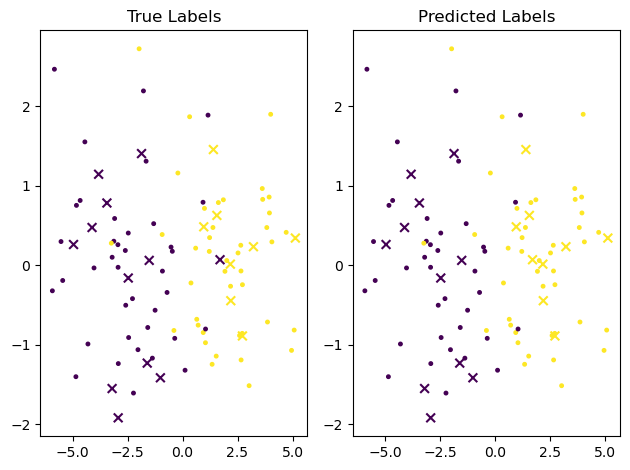

In [34]:
plt.subplot(1, 2, 1)
plt.scatter(training_set.iloc[:,0],training_set.iloc[:,1], s=25, c=training_set.iloc[:,-1], marker=".")
plt.scatter(holdout_set.iloc[:,0],holdout_set.iloc[:,1], s=40, c=holdout_set.iloc[:,-1], marker="x")
plt.title("True Labels")

plt.subplot(1, 2, 2)
plt.scatter(training_set.iloc[:,0],training_set.iloc[:,1], s=25, c=training_set.iloc[:,-1], marker=".")
plt.scatter(holdout_set.iloc[:,0],holdout_set.iloc[:,1], s=40, c=predicted_holdout_set.iloc[:,-1], marker="x")
plt.title("Predicted Labels")

plt.tight_layout()
plt.show()